# Notebook pour apprendre à recaler les tumeurs

In [1]:
from __future__ import print_function
import sys
import os
import logging
import six
from radiomics import featureextractor, getFeatureClasses
import radiomics
%config Completer.use_jedi = False
import SimpleITK as sitk
import nibabel as nib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import logging
import cv2
import scipy.ndimage as nd
from natsort import natsorted
from utils import get_all_good_slices, give_ls, get_good_slice, rescale_image, rescale_image_float, mask_superpose_simple, check_key_num

In [2]:
time_inj = ["_ART", "_PORT", "_TARD"]

### Print pour une slice les temps côté à côte

In [3]:
def eliminate_temps(name):
    useless_part_length = len(name.split('_')[-1]) + 1
    return(name[:-useless_part_length])

In [4]:
ls_image =sorted(glob.glob('./*_NAT*/*.nii'))
print(ls_image[1])
ls_image_no_time = natsorted(list(set([eliminate_temps(x) for x in ls_image])))
ls_image_full_times_surconfiance = [[name +time + ".nii" for time in time_inj] for name in ls_image_no_time ]
ls_image_full_time = []
dict_image_full_time = {}
for li_names in ls_image_full_times_surconfiance:
    present = True
    for name in li_names:
        if name not in ls_image:
            present = False
    if present:
        ls_image_full_time.append(li_names)
        classe_name = li_names[0].split('/')[-2].split('_')[1]
        patient_num = li_names[0].split('/')[-1].split('_')[0]
        dict_image_full_time[(patient_num, classe_name)] = li_names


./Dataset_CCK_NAT/10_PORT.nii


In [5]:
def show_all_time(num = None, key = None, slices = None, li_mask_external = None):
    names = check_key_num(num, key, ls_image_full_time, dict_image_full_time)
    if slices == None:
        slices = [get_good_slice(image_name = names[0]) for name in names] #sort la même slice que la première à chaque fois
    if li_mask_external == None:
        li_mask_external = [None for name in names]
    size = len(names)
    plt.subplots(1, size, figsize = (size*10, 10))
    for i,name in enumerate(names):
        mask_superpose_simple(name, slice_num = slices[i], other_mask = li_mask_external[i], num = i+1, max_num = size, legend = name.split('/')[-2].split('_')[1] + "_" + name.split('/')[-1].split('.')[0])
        
        
    
    

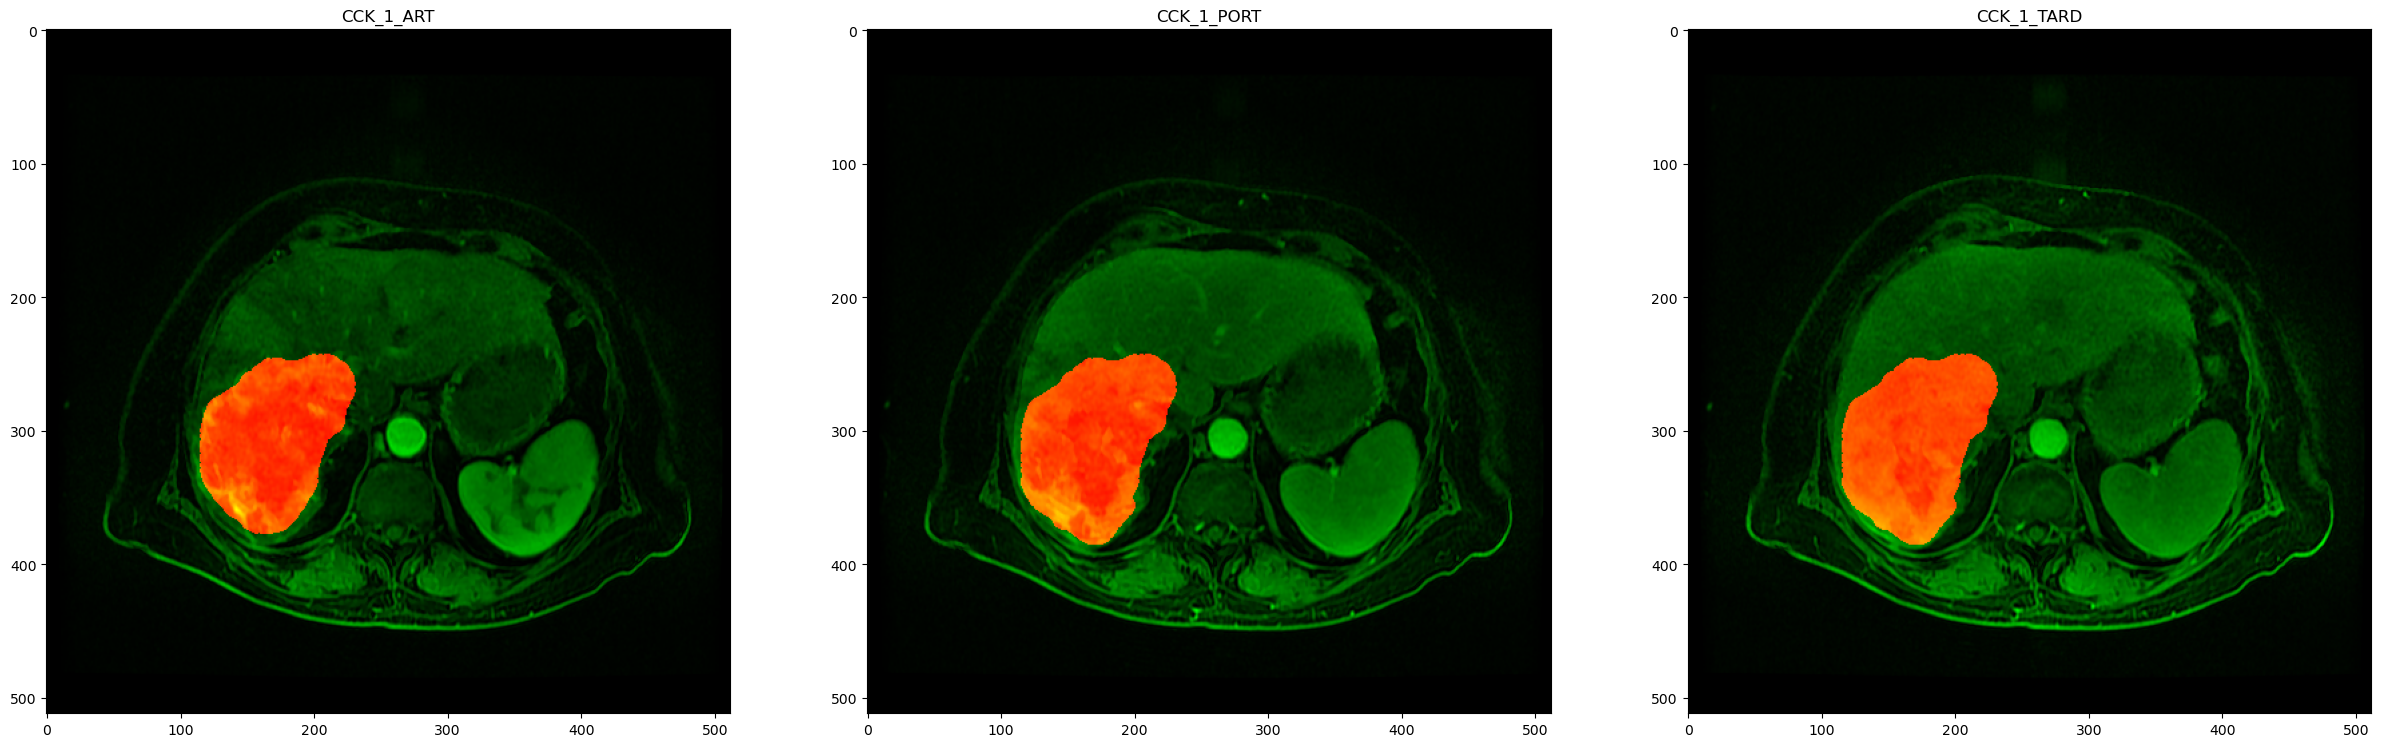

In [6]:
show_all_time(num = 0)

### Gérer les déséquilibres en nombre de slices de masque et translater le masque

In [47]:
# def calculate_new_spacing(original_size, original_spacing, new_size):
#     return [orig_size * orig_spacing / new_size for orig_size, orig_spacing, new_size in zip(original_size, original_spacing, new_size)]

def resample_image_to_reference(image, reference_image):
    # Obtenir l'espacement de l'image de référence
    reference_spacing = reference_image.GetSpacing()
    
    # Obtenir la taille de l'image de référence
    reference_size = reference_image.GetSize()
    
    # Obtenir l'origine de l'image de référence
    reference_origin = reference_image.GetOrigin()
    
    # Obtenir la direction de l'image de référence
    reference_direction = reference_image.GetDirection()
    
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()
    #new_spacing = calculate_new_spacing(original_size, original_spacing, reference_size)
    new_spacing= reference_spacing
    new_spacing = list(new_spacing)
    # print("ref", reference_spacing)
    # Définir le filtre de resegmentation
    resample = sitk.ResampleImageFilter()
    #new_spacing[2] = new_spacing[2]*1
    new_spacing= tuple(new_spacing)
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(reference_size)
    resample.SetOutputOrigin(reference_origin)
    resample.SetOutputDirection(reference_direction)
    resample.SetInterpolator(sitk.sitkLinear)
    
    # Appliquer la resegmentation
    resampled_image = resample.Execute(image)
    
    return resampled_image, resample

[1.25, 1.25, 3.5]
ref number [34, 35, 36, 37, 38, 39, 40, 41, 42]
problem number 7
corrected number 9
[36, 37, 38, 39, 40, 41, 42, 43, 44]


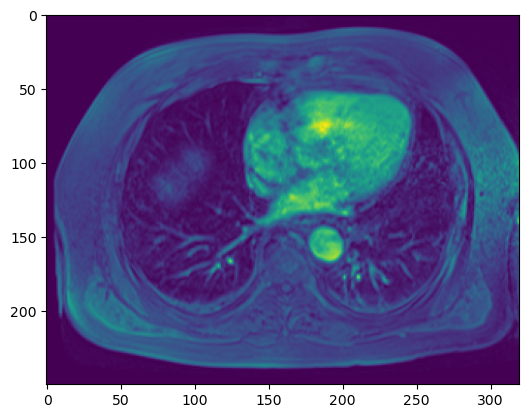

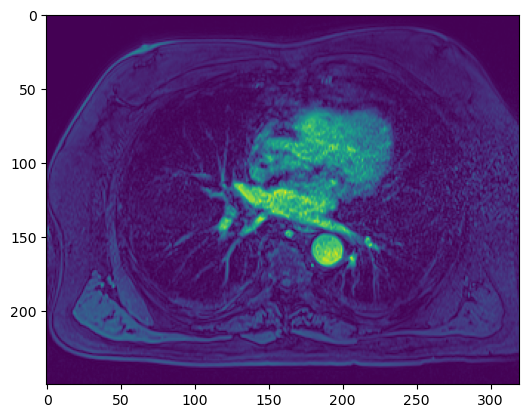

In [43]:
# num_im = 14
# time_ref = 1
# time = 0
# image_ref = sitk.ReadImage(ls_image_full_time[num_im][time_ref])
# mask_ref = sitk.ReadImage(ls_image_full_time[num_im][time_ref].replace('_NAT','').replace('.nii','_masked.nii') ) != 0
# image = sitk.ReadImage(ls_image_full_time[num_im][time])
# #print(image_ref.GetSize(),image.GetSize())
# new_im, resample = resample_image_to_reference(image, image_ref)
# #print(new_im.GetSize())
# mask = sitk.ReadImage(ls_image_full_time[num_im][time].replace('_NAT','').replace('.nii','_masked.nii') ) != 0
# new_mask = resample.Execute(mask) !=0
# print("ref number",get_all_good_slices(None,image_ref, mask_ref))
# print("problem number",len(get_all_good_slices(None,image, mask)))
# print("corrected number",len(get_all_good_slices(None, new_im, new_mask)))
# print(get_all_good_slices(None, new_im, new_mask))



In [48]:
def equalize_slices(num = None, key = None, show = True):
    names = check_key_num(num, key, ls_image_full_time, dict_image_full_time)
    names_masks = [name.replace('_NAT','').replace('.nii','_masked.nii') for name in names]
    li_masks = [(sitk.ReadImage(name_mask) !=0) for name_mask in names_masks]
    li_images = [sitk.ReadImage(name) for name in names]
    li_num_slice_tot = np.array([mask.GetSize()[2] for mask in li_masks])
    reference = max(li_num_slice_tot)
    differences = reference - li_num_slice_tot
    former_diff = np.copy(differences)
    if show:
        print("difference", differences)
    good_time = np.argmin(differences)
    for i in range(len(li_images)):
        if i != good_time:
            li_images[i], resample = resample_image_to_reference(li_images[i], li_images[good_time])
            li_masks[i] = resample.Execute(li_masks[i]) != 0
    
    
    li_slices = [[sitk.GetArrayFromImage(mask[:,:,z]).astype(int)  for z in range(li_num_slice_tot[i])] for i,mask in enumerate(li_masks)]
    li_num_slice_tot = np.array([mask.GetSize()[2] for mask in li_masks])
    reference = max(li_num_slice_tot)
    differences = reference - li_num_slice_tot
    for i,li_slices_time_t in enumerate(li_slices):
        difference = differences[i]
        if difference > 0:
            print("TRES ETRANGE, new differences:", differences, "avant on avait", former_diff)
            size = li_slices_time_t[0].shape
            for _ in range(difference//2):
                li_slices_time_t.append(np.zeros(size))
                li_slices_time_t.insert(0, np.zeros(size))
            if difference%2 == 1:
                li_slices_time_t.append(np.zeros(size))
    return li_slices

In [188]:
def shift_vertical_with_zeros(mat, shift=1):
    shift = - shift
    if shift == 0:
        return mat
    elif shift > 0:
        if shift >= mat.shape[0]:
            return np.zeros_like(mat)
        return np.vstack([np.zeros((shift, mat.shape[1])), mat[:-shift]])
    else:
        shift = abs(shift)
        if shift >= mat.shape[0]:
            return np.zeros_like(mat)
        return np.vstack([mat[shift:], np.zeros((shift, mat.shape[1]))])
    


def shift_horizontal_with_zeros(mat, shift=1):
    if shift == 0:
        return mat
    elif shift > 0:
        if shift >= mat.shape[1]:
            return np.zeros_like(mat)
        return np.hstack([np.zeros((mat.shape[0], shift)), mat[:, :-shift]])
    else:
        shift = abs(shift)
        if shift >= mat.shape[1]:
            return np.zeros_like(mat)
        return np.hstack([mat[:, shift:], np.zeros((mat.shape[0], shift))])


def move(li_slices_time_t, delta_x, delta_y, delta_z):
    li_slices_time_t = [shift_horizontal_with_zeros(slice, delta_x) for slice in li_slices_time_t]
    li_slices_time_t = [shift_vertical_with_zeros(slice, delta_y) for slice in li_slices_time_t]
    if delta_z >0:
        li_slices_time_t = li_slices_time_t[delta_z:]
        li_slices_time_t = li_slices_time_t + [np.zeros_like(li_slices_time_t[0]) for i in range(delta_z)]
    if delta_z <0:
        li_slices_time_t = li_slices_time_t[:delta_z]
        li_slices_time_t = [np.zeros_like(li_slices_time_t[0]) for i in range(-delta_z)] + li_slices_time_t

    return li_slices_time_t
    
    

    
    
    
    
    

### Calculer les produits scalaires

In [189]:
def calc_ps(li_slices_time_t_1, li_slices_time_t_2, mode = "simple"):
    ps = 0
    #print(len(li_slices_time_t_1), len(li_slices_time_t_2))
    if mode == "simple":
        for i in range(len(li_slices_time_t_1)):
            ps += np.sum(np.bitwise_and(li_slices_time_t_1[i].astype(bool),li_slices_time_t_2[i].astype(bool)))
    elif mode == "area":
        for i in range(len(li_slices_time_t_1)):
            ps += np.sum(li_slices_time_t_1[i]) * np.sum(li_slices_time_t_2[i]) 
    else:
        raise Exception("No mode of ps calculus")
        
    return ps

def calc_ps_decal(li_slices_time_t_ref, li_slices_time_t_2, delta_x, delta_y, delta_z, mode = "simple"):
    li_slices_time_t_2 = move(li_slices_time_t_2, delta_x, delta_y, delta_z)
    #print(delta_x, delta_y, delta_z)
    return calc_ps(li_slices_time_t_ref, li_slices_time_t_2, mode = mode)

In [190]:
fenetre_x  = range(1)
fenetre_y  = range(1)
fenetre_z  = range(-30,30)

def find_best_decal(li_slices_time_t_ref, li_slices_time_t_2):
    ps_max = 0
    best_decal = [0,0,0]
    for delta_x in fenetre_x:
        for delta_y in fenetre_y:
            for delta_z in fenetre_z:
                ps = calc_ps_decal(li_slices_time_t_ref, li_slices_time_t_2, delta_x, delta_y, delta_z)
                #print(ps)
                if ps > ps_max:
                    ps_max = ps
                    best_decal = [delta_x, delta_y, delta_z]
    return best_decal

def find_best_z_decal(li_slices_time_t_ref, li_slices_time_t_2):
    ps_max = 0
    best_decal = 0
    for delta_z in fenetre_z:
        ps = calc_ps_decal(li_slices_time_t_ref, li_slices_time_t_2, 0,0, delta_z, mode = "area")
        #print(ps)
        if ps > ps_max:
            ps_max = ps
            best_decal = delta_z
    return best_decal

def find_best_decal_all_times(num = None, key = None, mode = "simple"):
    names = check_key_num(num, key, ls_image_full_time, dict_image_full_time)
    #def resample_image_to_reference(image, reference_image):
    li_slices = equalize_slices(num = num, key = key)
    li_slices_time_t_ref = li_slices[0]
    if mode == "simple":
        li_best_decal = [[0,0,0]] + [find_best_decal(li_slices_time_t_ref, li_slices_time_t_other)  for li_slices_time_t_other in li_slices[1:]]
    if mode == "area":
        li_best_decal = [0] + [find_best_z_decal(li_slices_time_t_ref, li_slices_time_t_other) for li_slices_time_t_other in li_slices[1:]]
    return li_best_decal

In [202]:
find_best_decal_all_times(num = 7, mode = "simple")

difference [0 0 0]


[[0, 0, 0], [0, 0, 0], [0, 0, 0]]

In [210]:
# for num in range(len(ls_image_full_time)):
#     names = check_key_num(num,None, ls_image_full_time, dict_image_full_time)
#     li_dims_images = [np.array(list(sitk.ReadImage(name).GetSize()))*np.array(list(sitk.ReadImage(name).GetSpacing())) for name in names]
#     names_masks = [name.replace('_NAT','').replace('.nii','_masked.nii') for name in names]
#     li_masks = [(sitk.ReadImage(name_mask) !=0) for name_mask in names_masks]
#     li_num_slice_tot = np.array([mask.GetSize()[2] for mask in li_masks])
#     reference = max(li_num_slice_tot)
#     differences = reference - li_num_slice_tot
#     if sum(differences) > 0:
#         print(num,names, differences, "dimensions", li_dims_images)
        

1 ['./Dataset_CCK_NAT/2_ART.nii', './Dataset_CCK_NAT/2_PORT.nii', './Dataset_CCK_NAT/2_TARD.nii'] [ 0  0 72] dimensions [array([380.00640869, 380.00640869, 200.00019073]), array([380.00640869, 380.00640869, 200.00019073]), array([380.00640869, 380.00640869, 196.00021362])]
14 ['./Dataset_CCK_NAT/17_ART.nii', './Dataset_CCK_NAT/17_PORT.nii', './Dataset_CCK_NAT/17_TARD.nii'] [40  0  0] dimensions [array([420.        , 420.        , 136.03161621]), array([400. , 312.5, 224. ]), array([400. , 312.5, 224. ])]
25 ['./Dataset_CHC_NAT/18_ART.nii', './Dataset_CHC_NAT/18_PORT.nii', './Dataset_CHC_NAT/18_TARD.nii'] [0 0 8] dimensions [array([351.    , 285.1875, 240.    ]), array([351.    , 285.1875, 240.    ]), array([351.    , 285.1875, 216.    ])]
27 ['./Dataset_CHC_NAT/20_ART.nii', './Dataset_CHC_NAT/20_PORT.nii', './Dataset_CHC_NAT/20_TARD.nii'] [44  0  0] dimensions [array([440.01278687, 440.01278687, 220.00020981]), array([400.02560425, 400.02560425, 211.20020771]), array([400.02560425, 400

38
[9, 10, 11, 12, 13, 14, 15]
[34, 35, 36, 37, 38, 39, 40, 41, 42]
[35, 36, 37, 38, 39, 40, 41, 42]


IndexError: index 38 is outside the extent for dimension 2 with size 24

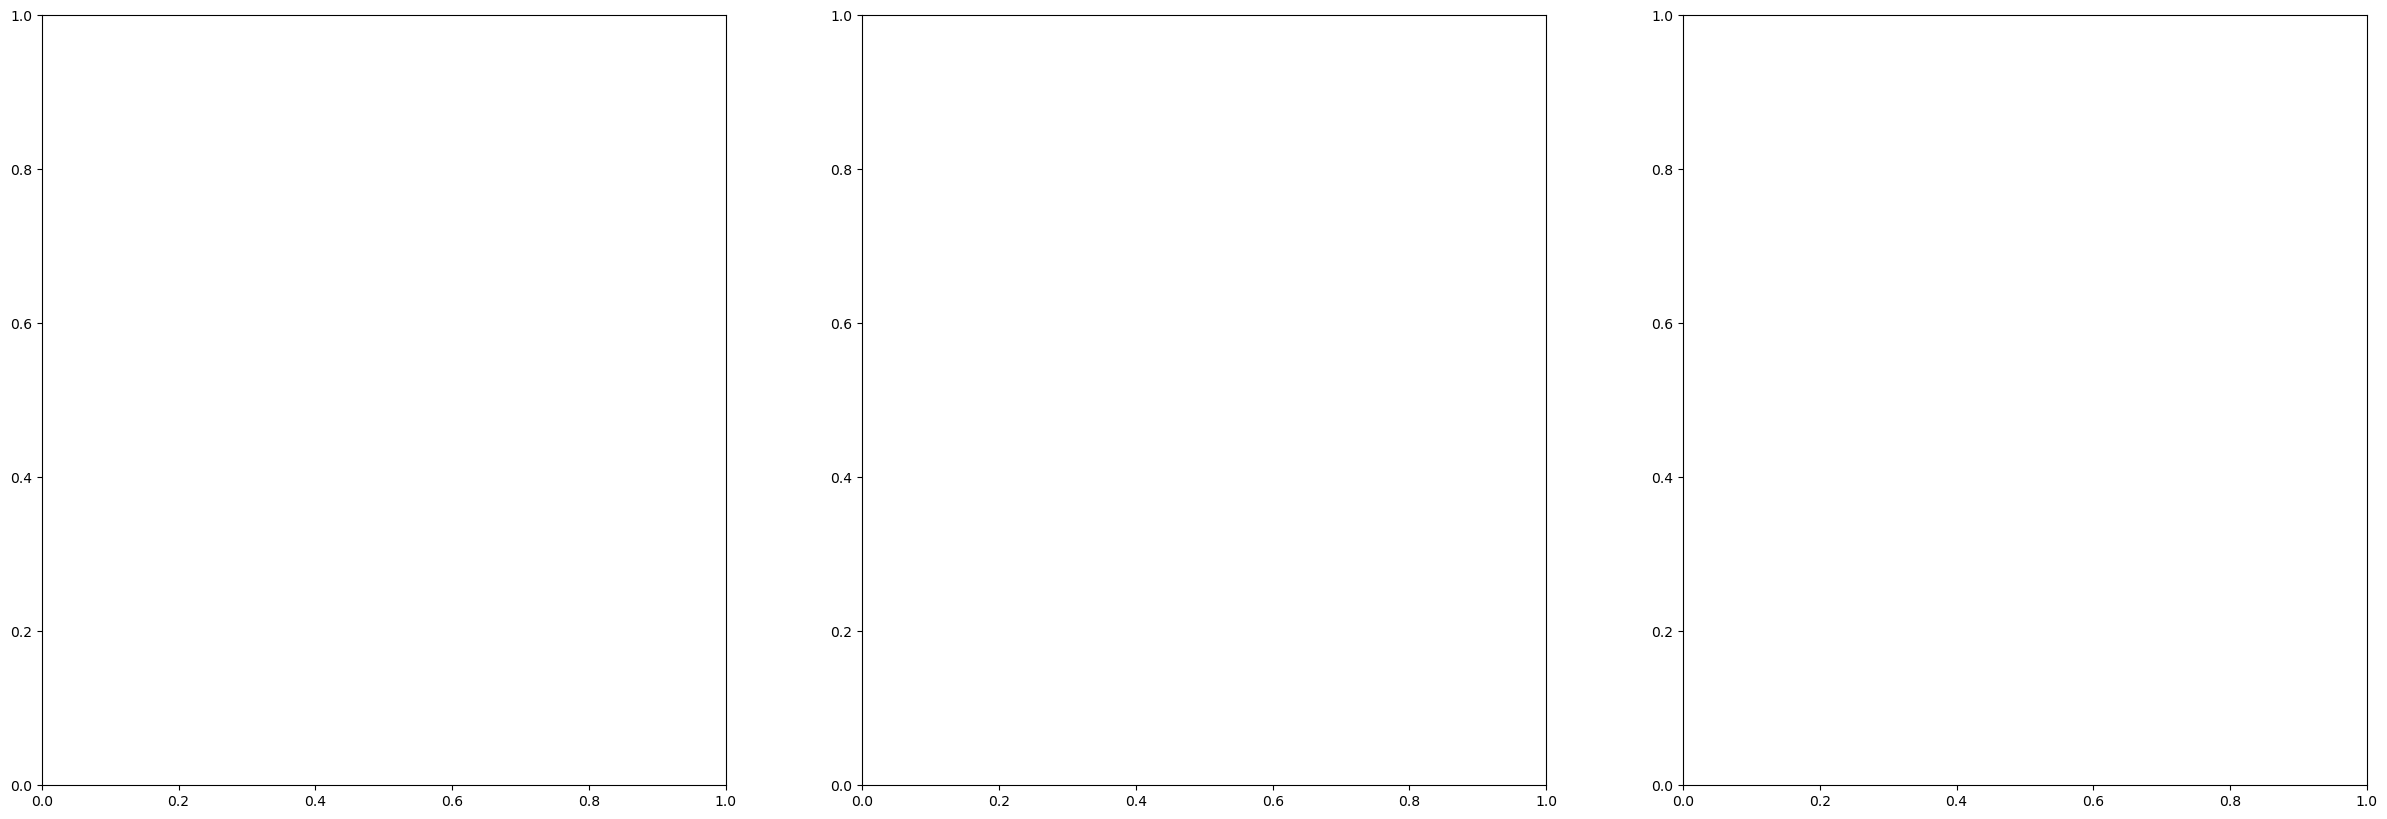

In [207]:
num = 14
slice_ref = get_good_slice(image_name = ls_image_full_time[num][1])
print(slice_ref)
print(get_all_good_slices(image_name = ls_image_full_time[num][0]))
print(get_all_good_slices(image_name = ls_image_full_time[num][1]))
print(get_all_good_slices(image_name = ls_image_full_time[num][2]))
show_all_time(num = num, slices = [slice_ref, slice_ref + 1, slice_ref + 1])

